In [2]:
import cv2
from matplotlib import pyplot
import numpy
from scipy.fftpack import dct
from scipy.fftpack import idct
import struct
import zlib

# Zadanie 1

In [3]:
#
# PPM file header
#

width = 50
height = 50
max_color_value = 255

ppm_ascii_header = f'P3\n{width} {height}\n{max_color_value}\n' 
ppm_binary_header = f'P6\n{width} {height}\n{max_color_value}\n' 

#
# Image data
#
image = numpy.random.randint(0, max_color_value + 1, size=(height, width, 3), dtype=numpy.uint8)

#
# Save the PPM image as an ASCII file
#
with open('lab4-ascii.ppm', 'w') as fh:
    fh.write(ppm_ascii_header)
    image.tofile(fh, sep=' ')
    fh.write('\n')

#
# Save the PPM image as a binary file
#
with open('lab4-binary.ppm', 'wb') as fh:
    fh.write(bytearray(ppm_binary_header, 'ascii'))
    image.tofile(fh)

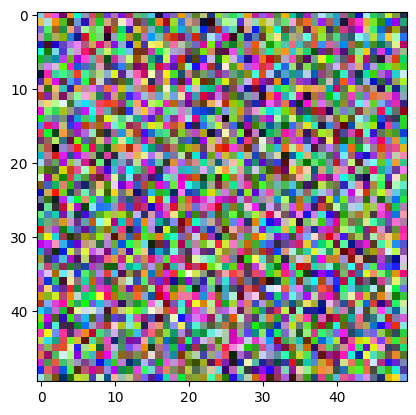

In [4]:
#
# Display image
#
image_from_file = cv2.imread('lab4-ascii.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

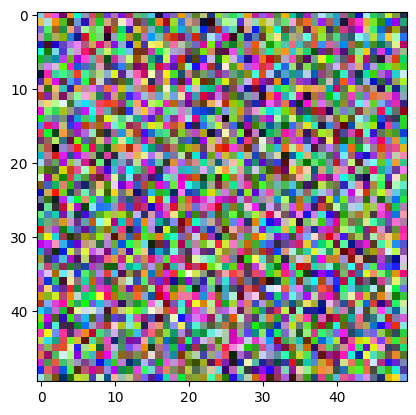

In [5]:
#
# Display image
#
image_from_file = cv2.imread('lab4-binary.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Zadanie 2

In [6]:
width = 1120
height = 64
max_color_value = 255

ppm_ascii_header = f'P3\n{width} {height}\n{max_color_value}\n'

black = numpy.array([0, 0, 0], dtype=numpy.uint8)
blue = numpy.array([0, 0, 255], dtype=numpy.uint8)
cyan = numpy.array([0, 255, 255], dtype=numpy.uint8)
green = numpy.array([0, 255, 0], dtype=numpy.uint8)
yellow = numpy.array([255, 255, 0], dtype=numpy.uint8)
red = numpy.array([255, 0, 0], dtype=numpy.uint8)
magenta = numpy.array([255, 0, 255], dtype=numpy.uint8)
white = numpy.array([255, 255, 255], dtype=numpy.uint8)

colors = [black, blue, cyan, green, yellow, red, magenta, white]

image = numpy.zeros((height, width, 3), dtype=numpy.uint8)

segment = width // (len(colors) - 1)


for i in range((len(colors) - 1)):
    for j in range(3):
     image[:, i * segment:(i + 1) * segment, j] = numpy.linspace(colors[i][j], colors[i + 1][j], segment)




#save as png
cv2.imwrite('lab4-rainbow.png', image)


with open('lab4-rainbow.ppm', 'w') as fh:
    fh.write(ppm_ascii_header)
    image.tofile(fh, sep=' ')
    fh.write('\n')

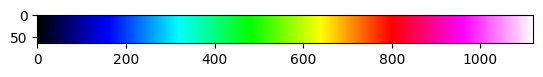

In [7]:
#
# Display image
#
image_from_file = cv2.imread('lab4-rainbow.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Zadanie 3

In [8]:
#
# Image data
#
image = cv2.imread('lab4-rainbow.ppm')

#
# Construct signature
#
#89 50 4E 47 0D 0A 1A 0A
png_file_signature = b'\x89\x50\x4E\x47\x0D\x0A\x1A\x0A'
 
#
# Construct header
#
header_id = b'IHDR'  # TODO: implement
header_content = struct.pack('!2I5B', width, height, 8, 2, 0, 0, 0) 
header_size = struct.pack('!I', len(header_content)) 
header_crc = struct.pack('!I', zlib.crc32(header_id + header_content)) 
png_file_header = header_size + header_id + header_content + header_crc

#
# Construct data
#
data_id = b'IDAT'  # TODO: implement
data_content = zlib.compress(b''.join([b'\x00' + bytes(row) for row in image]))
data_size = struct.pack('!I', len(data_content))  
data_crc =  struct.pack('!I', zlib.crc32(data_id + data_content))
png_file_data = data_size + data_id + data_content + data_crc

#
# Consruct end
#
end_id = b'IEND'
end_content = b''
end_size = struct.pack('!I', len(end_content))
end_crc = struct.pack('!I', zlib.crc32(end_id + end_content))
png_file_end = end_size + end_id + end_content + end_crc

#
# Save the PNG image as a binary file
#
with open('lab4.png', 'wb') as fh:
    fh.write(png_file_signature)
    fh.write(png_file_header)
    fh.write(png_file_data)
    fh.write(png_file_end)

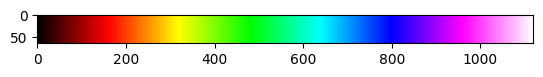

In [9]:
#
# Display image
#
image_from_file = cv2.imread('lab4.png')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Funkcje pomocnicze do zadań 4 i 5

In [10]:
#
# 2d Discrete Cosinus Transform
#
def dct2(array):
    return dct(dct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def idct2(array):
    return idct(idct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


#
# Calculate quantisation matrices
#
# Based on: https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html
#           #step-3-and-4-discrete-cosinus-transform-and-quantisation
#
_QY = numpy.array([[16, 11, 10, 16, 24, 40, 51, 61],
                   [12, 12, 14, 19, 26, 48, 60, 55],
                   [14, 13, 16, 24, 40, 57, 69, 56],
                   [14, 17, 22, 29, 51, 87, 80, 62],
                   [18, 22, 37, 56, 68, 109, 103, 77],
                   [24, 35, 55, 64, 81, 104, 113, 92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])

_QC = numpy.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])


def _scale(QF):
    if QF < 50 and QF >= 1:
        scale = numpy.floor(5000 / QF)
    elif QF < 100:
        scale = 200 - 2 * QF
    else:
        raise ValueError('Quality Factor must be in the range [1..99]')

    scale = scale / 100.0
    return scale


def QY(QF=85):
    return _QY * _scale(QF)


def QC(QF=85):
    return _QC * _scale(QF)

# Zadania 4 i 5

In [11]:
import numpy as np
import zlib
import sys
from skimage.transform import resize
import cv2



# 0. Image data
image = cv2.imread('lab4.png')
height, width, _ = image.shape

# 1. Convert RGB to YCbCr
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# 2. Downsampling on Cb and Cr channels
y = ycbcr_image[:, :, 0]
cb = ycbcr_image[:, :, 1]
cr = ycbcr_image[:, :, 2]

downsampled_cb = cv2.resize(cb, (width // 2, height // 2))
downsampled_cr = cv2.resize(cr, (width // 2, height // 2))

# 3. Produce 8x8 blocks
def split_channel_to_blocks(channel):
    """Splits channel into blocks 8x8"""
    blocks = []
    for i in range(0, channel.shape[0], 8):
        for j in range(0, channel.shape[1], 8):
            blocks.append(channel[i:i + 8, j:j + 8])
    return blocks

blocks_y = split_channel_to_blocks(y)
blocks_cb = split_channel_to_blocks(downsampled_cb)
blocks_cr = split_channel_to_blocks(downsampled_cr)

# 4. Calculate DCT on each block
dct_blocks_y = [dct2(block) for block in blocks_y]
dct_blocks_cb = [dct2(block) for block in blocks_cb]
dct_blocks_cr = [dct2(block) for block in blocks_cr]



# # 5. Divide each block by quantisation matrix
dct_blocks_y = [np.round(block / QY()) for block in dct_blocks_y]
dct_blocks_cb = [np.round(block / QC()) for block in dct_blocks_cb]
dct_blocks_cr = [np.round(block / QC()) for block in dct_blocks_cr]


# # 6. Round values in each block to integers
dct_blocks_y = [block.astype(np.int32) for block in dct_blocks_y]
dct_blocks_cb = [block.astype(np.int32) for block in dct_blocks_cb]
dct_blocks_cr = [block.astype(np.int32) for block in dct_blocks_cr]

# 7. Zig Zag
def zig_zag(block):
    return np.concatenate([np.diagonal(block[::-1, :], k)[::(2 * (k % 2) - 1)] for k in range(1 - block.shape[0], block.shape[0])])

zig_zag_blocks_y = [zig_zag(block) for block in dct_blocks_y]
zig_zag_blocks_cb = [zig_zag(block) for block in dct_blocks_cb]
zig_zag_blocks_cr = [zig_zag(block) for block in dct_blocks_cr]


# 8. Flatten, concatenate, compress and calculate the size -- how many bytes?
def compress(blocks):
    return zlib.compress(np.concatenate(blocks).tobytes())

compressed_y = compress(zig_zag_blocks_y)
compressed_cb = compress(zig_zag_blocks_cb)
compressed_cr = compress(zig_zag_blocks_cr)


import sys

print(sys.getsizeof(compressed_y) + sys.getsizeof(compressed_cb) + sys.getsizeof(compressed_cr))

# 7'. Undo Zig Zag
# We can skip it in this exercise! We did Zig Zag only for analysis in step 8.
# You can continue with result from step 6. instead of implementing undo here.

# 6'. Nothing to do here   ¯\_(ツ)_/¯
# No conversion is really needed here, just proceed to the next step.

# 5'. Reverse division by quantisation matrix -- multiply
dct_blocks_y = [block * QY() for block in dct_blocks_y]
dct_blocks_cb = [block * QC() for block in dct_blocks_cb]
dct_blocks_cr = [block * QC() for block in dct_blocks_cr]

# 4'. Reverse DCT
idct_blocks_y = [idct2(block) for block in dct_blocks_y]
idct_blocks_cb = [idct2(block) for block in dct_blocks_cb]
idct_blocks_cr = [idct2(block) for block in dct_blocks_cr]

# 3'. Combine 8x8 blocks to original image
def merge_blocks_to_channel(blocks, width):
    """Merge 8x8 blocks into """
    step = int(width / 8)
    rows = []
    for i in range(0, len(blocks), step):
        rows.append(np.concatenate(blocks[i:i + step], axis=1))
    channel = np.concatenate(rows, axis=0)
    return channel

y = merge_blocks_to_channel(idct_blocks_y, width)
cb = merge_blocks_to_channel(idct_blocks_cb, width // 2)
cr = merge_blocks_to_channel(idct_blocks_cr, width // 2)



# 2'. Upsampling on Cb and Cr channels from downsampled_cb and downsampled_cr
upsampled_cb = cv2.resize(cb, (width, height), interpolation=cv2.INTER_NEAREST)
upsampled_cr = cv2.resize(cr, (width, height), interpolation=cv2.INTER_NEAREST)

# 1'. Convert YCbCr to RGB
ycbcr_image = np.stack([y, upsampled_cr, upsampled_cb], axis=2)
ycbcr_image = np.clip(ycbcr_image, 0, 255)
ycbcr_image = ycbcr_image.astype(np.uint8)
ycbcr_image = cv2.cvtColor(ycbcr_image, cv2.COLOR_YCrCb2RGB)

# 0'. Save the decoded image -- as PPM or PNG
cv2.imwrite('lab4-po-kompresji-i-dekompresji-jpeg.png', ycbcr_image)

5795


True

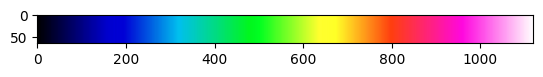

In [12]:
# Display image
image_from_file = cv2.imread('lab4-po-kompresji-i-dekompresji-jpeg.png')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Obserwacje z zadań 4 i 5

[[0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]]


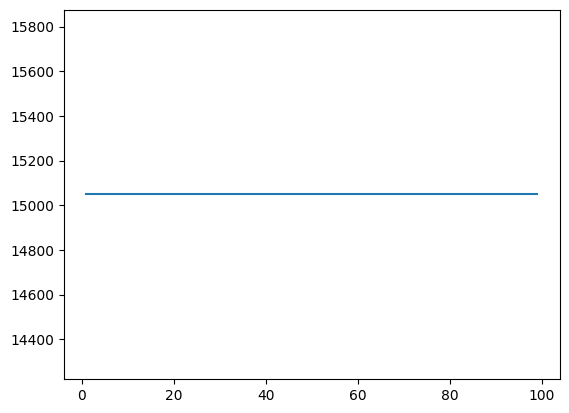

In [21]:
#DO CZWARTEGO
# bez 11802b
# co drugi 5795b
# co czwarty 4779b



# DO PIĄTEGO

# 0. Image data
image = cv2.imread('lab4.png')
height, width, _ = image.shape

# 1. Convert RGB to YCbCr
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# 2. Downsampling on Cb and Cr channels
y = ycbcr_image[:, :, 0]
cb = ycbcr_image[:, :, 1]
cr = ycbcr_image[:, :, 2]

downsampled_cb = cv2.resize(cb, (width // 2, height // 2))
downsampled_cr = cv2.resize(cr, (width // 2, height // 2))

def split_channel_to_blocks(channel):
    blocks = []
    for i in range(0, channel.shape[0], 8):
        for j in range(0, channel.shape[1], 8):
            blocks.append(channel[i:i + 8, j:j + 8])
    return blocks

blocks_y = split_channel_to_blocks(y)
blocks_cb = split_channel_to_blocks(downsampled_cb)
blocks_cr = split_channel_to_blocks(downsampled_cr)


# 4. Calculate DCT on each block
dct_blocks_y = [dct2(block) for block in blocks_y]
dct_blocks_cb = [dct2(block) for block in blocks_cb]
dct_blocks_cr = [dct2(block) for block in blocks_cr]

sizes = []

for i in range(1,100):
    dct_blocks_y = [block / QY(i) for block in dct_blocks_y]
    dct_blocks_cb = [block / QC(i) for block in dct_blocks_cb]
    dct_blocks_cr = [block / QC(i) for block in dct_blocks_cr]


    dct_blocks_y = [block.astype(np.int32) for block in dct_blocks_y]
    dct_blocks_cb = [block.astype(np.int32) for block in dct_blocks_cb]
    dct_blocks_cr = [block.astype(np.int32) for block in dct_blocks_cr]

    sizes.append(sys.getsizeof(dct_blocks_y) + sys.getsizeof(dct_blocks_cb) + sys.getsizeof(dct_blocks_cr))


pyplot.plot(range(1,100), sizes)
pyplot.show()






